In [1]:
# Setup the library
import pyrogue as pr
import h5py
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

#constants
ACQUIRE_C = True
#STEP OF 1 IS PREFFERED FOR MISSING CODE IDENTIFICATION, INL, DNL
#STEP OF 10 IS PREFFERED FOR DYNAMIC RANGE
SCAN_STEP_C = 10
CONVERT_C = True
ANALYSE_C = True

filename = '/u2/ddoering/ePixHR10kT_ASIC3_V3_externalRamp_320MHz_ScanStep_10_run1.dat'

h5_filename = os.path.splitext(filename)[0]+".hdf5"


In [2]:
# Create and start the root class
if ACQUIRE_C :
    root = epix_hr_single_10k.RootLCLSIITiming(
        top_level   = top_level,
        dev         = '/dev/datadev_1',
        sim         = False,
        asicVersion = 3
    )
    root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
if ACQUIRE_C :
    AxiVersion = root.Core.AxiVersion
    print ( '###################################################')
    print ( '#             Firmware Version                    #')
    print ( '###################################################')
    AxiVersion.printStatus()
    print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 4 days, 22:49:28
GitHash      = 0x91b9a02f0d07162a78f04638906d35cf1ed23caf
XilinxDnaId  = 0x400200010139f5e11ce12205
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Fri 30 Sep 2022 01:25:56 PM PDT
Builder      = ddoering
###################################################


In [135]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kT'
bitMask               = 0xffff

def getData(localFile):

    file_header = [0]
    numberOfFrames = 0
    previousSize = 0
    while ((len(file_header)>0) and ((numberOfFrames<MAX_NUMBER_OF_FRAMES_PER_BATCH) or (MAX_NUMBER_OF_FRAMES_PER_BATCH==-1))):
        try:
            # reads file header [the number of bytes to read, EVIO]
            file_header = np.fromfile(localFile, dtype='uint32', count=2)
            payloadSize = int(file_header[0]/2)-2 #-1 is need because size info includes the second word from the header
            newPayload = np.fromfile(f, dtype='uint16', count=payloadSize) #(frame size splited by four to read 32 bit 
            #save only serial data frames
            if (numberOfFrames == 0):
                allFrames = [newPayload.copy()]
            else:
                newFrame  = [newPayload.copy()]
                allFrames = np.append(allFrames, newFrame, axis = 0)
            numberOfFrames = numberOfFrames + 1 
            #print ("Payload" , numberOfFrames, ":",  (newPayload[0:5]))
            previousSize = file_header
       
            if (numberOfFrames%1000==0):
                print("Read %d frames" % numberOfFrames)

        except Exception: 
            e = sys.exc_info()[0]
            #print ("Message\n", e)
            print ('\r', 'numberOfFrames read:', numberOfFrames, 'Size Error, currnt size', file_header, 'previous size', previousSize)
            

    return allFrames

def getDescImaData(localAllFrames):
##################################################
# image descrambling
##################################################
    numberOfFrames = localAllFrames.shape[0]
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
#numberOfFrames = allFrames.shape[0]
    print("numberOfFrames in the 3D array: " ,numberOfFrames)
    print("Starting descrambling images")
    currentRawData = []
    imgDesc = []
    if(numberOfFrames==1):
        [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData = [], newRawData = allFrames[0])
        imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
    else:
        for i in range(0, numberOfFrames):
        #get an specific frame
            [frameComplete, readyForDisplay, rawImgFrame] = currentCam.buildImageFrame(currentRawData, newRawData = localAllFrames[i,:])
            currentRawData = rawImgFrame

        #get descrambled image from camera
            if (len(imgDesc)==0 and (readyForDisplay)):
                imgDesc = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                currentRawData = []
            else:
                if readyForDisplay:
                    currentRawData = []
                    newImage = np.array([currentCam.descrambleImage(bytearray(rawImgFrame.tobytes()))])
                #newImage = currentCam.descrambleImage(rawImgFrame)
                #newImage = newImage.astype(np.float, copy=False)
                #if (np.sum(np.sum(newImage))==0):
                #    newImage[np.where(newImage==0)]=np.nan
                    imgDesc = np.concatenate((imgDesc, np.array([newImage[0]])),0)

    return imgDesc

def printname(name):
    print (name)

def setADC (RefGenB = 3, RefGenC = 2, S2D_1_b = 0, shvc_DAC = 23, S2dDacBias = 3):
    print('Original values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())
    
    ASIC.RefGenB.set(RefGenB) #2 bits
    ASIC.RefGenC.set(RefGenC) #2 bits
    ASIC.S2D_1_b.set(S2D_1_b) #3 bits
    ASIC.shvc_DAC.set(shvc_DAC) #6 bits
    ASIC.S2dDacBias.set(S2dDacBias)
    
    print('New values')
    print('RefGenB', ASIC.RefGenB.get())
    print('RefGenC',ASIC.RefGenC.get())
    print('S2D_1_b',ASIC.S2D_1_b.get())
    print('shvc_DAC',ASIC.shvc_DAC.get())
    print('S2dDacBias',ASIC.S2dDacBias.get())

In [4]:
#Initialze the camera
if ACQUIRE_C :
    #[routine, asic0, asic1, asic2, asic3]'
    root.EpixHR.InitASIC([4,0,0,0,1])



Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 2
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_3.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.Epi

In [23]:
if ACQUIRE_C :
    #sets ASIC to point to the external DAC
    ASIC.mTest.set(True)

In [24]:
if ACQUIRE_C :
    #Makes sure triggers are off
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    time.sleep(10)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

In [25]:
if ACQUIRE_C :
    #use system with batcher and missing ASICs
    root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
    print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
    #Only ASIC 1 is available so disable the 6 lower lanes
    root.EpixHR.PacketRegisters1.DisableLane.set(0x3F)
    #using internal triggers, so bypassing timing channel at the batcher 
    root.EpixHR.BatcherEventBuilder1.Bypass.set(1)

Locked lanes: fc0000


In [26]:
if ACQUIRE_C :
    #points to the ASIC device under test
    ASIC = root.EpixHR.Hr10kTAsic3

    root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
    root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)#Makes sure triggers are off

    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)

    #sets HSDAC device
    root.EpixHR.HSDac.enable.set(True)
    #reset status
    root.EpixHR.HSDac.WFEnabled.set(False)
    root.EpixHR.HSDac.waveformSource.set(0)
    root.EpixHR.HSDac.externalUpdateEn.set(False)
    root.EpixHR.HSDac.run.set(False)

    #configure
    root.EpixHR.HSDac.rCStartValue.set(0)
    root.EpixHR.HSDac.rCStopValue.set(65535)
    root.EpixHR.HSDac.rCStep.set(SCAN_STEP_C)
    root.EpixHR.HSDac.WFEnabled.set(True)
    root.EpixHR.HSDac.waveformSource.set(1)
    root.EpixHR.HSDac.externalUpdateEn.set(True)
    root.EpixHR.HSDac.run.set(True)


In [27]:
if ACQUIRE_C :
    # Remove previous dataset
    #if os.path.isfile(f'{top_level}/test.dat'):
    #    os.remove(f'{top_level}/test.dat')    
    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    

    
    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(100000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()

    # Wait for the file write to write the 10 waveforms
    while(writer.getFrameCount() < int(65535/SCAN_STEP_C)):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

Aquisition Counter 3578887
Number of frames received: 5003
Number of frames received: 6004
Delta Aquisition Counter: 7006
Number of frames received: 7006


In [32]:
if CONVERT_C :
    from importlib import reload
    reload(cameras)
    
    if os.path.isfile(f'{h5_filename}'):
        os.remove(f'{h5_filename}')    

    MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
    cameraType            = 'ePixHr10kTBatcher'
    bitMask               = 0xffff
    currentCam = cameras.Camera(cameraType = cameraType)
    currentCam.bitMask = bitMask
    currentCam.MAX_NUMBER_OF_FRAMES_PER_BATCH  = MAX_NUMBER_OF_FRAMES_PER_BATCH

    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(round(66/SCAN_STEP_C)):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    #numberOfFrames = allFrames.shape[0]
    SAVEHDF5 = True
    if(SAVEHDF5):
        print("Saving Hdf5")       
        f = h5py.File(h5_filename, "w")
        for i in range(0,6):
            f['header_%d'%i] = headers[:,i]
        f['adcData'] = imgDesc.astype('uint16')
        f.close()



Camera  ePixHr10kTBatcher  selected.
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 3
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 4
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 5
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 6
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
Saving Hdf5


adcData
header_0
header_1
header_2
header_3
header_4
header_5
(7000, 144, 384)


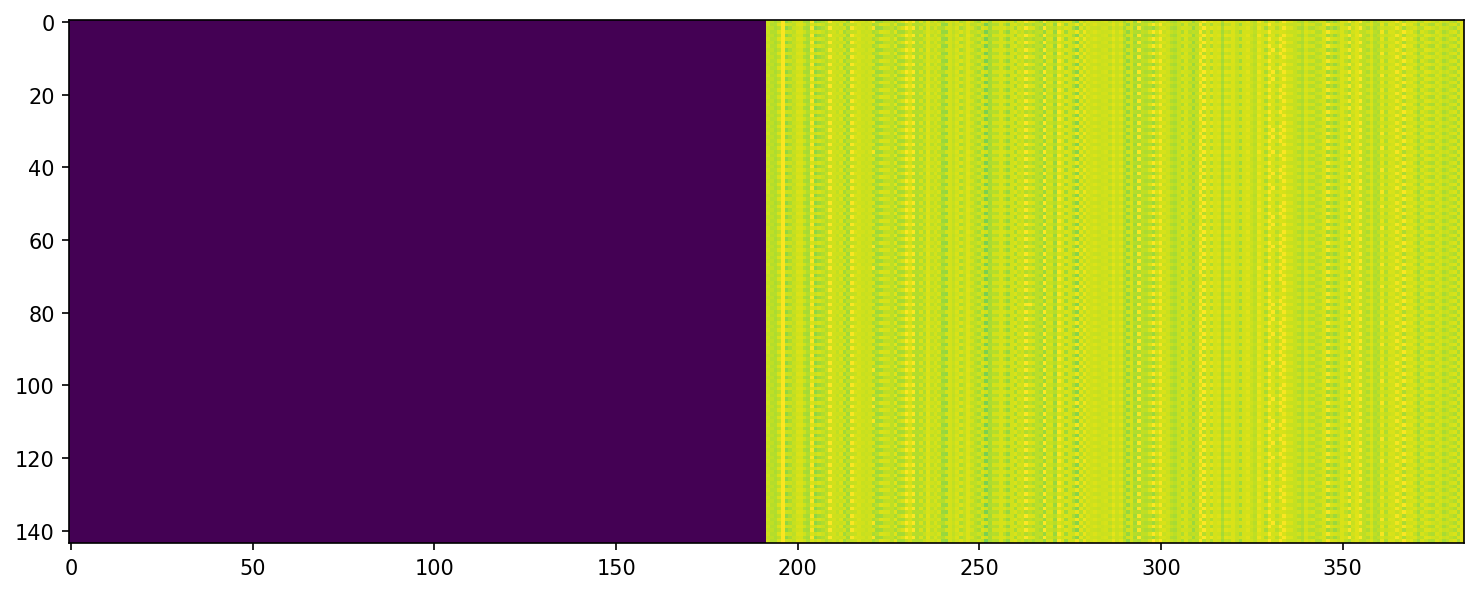

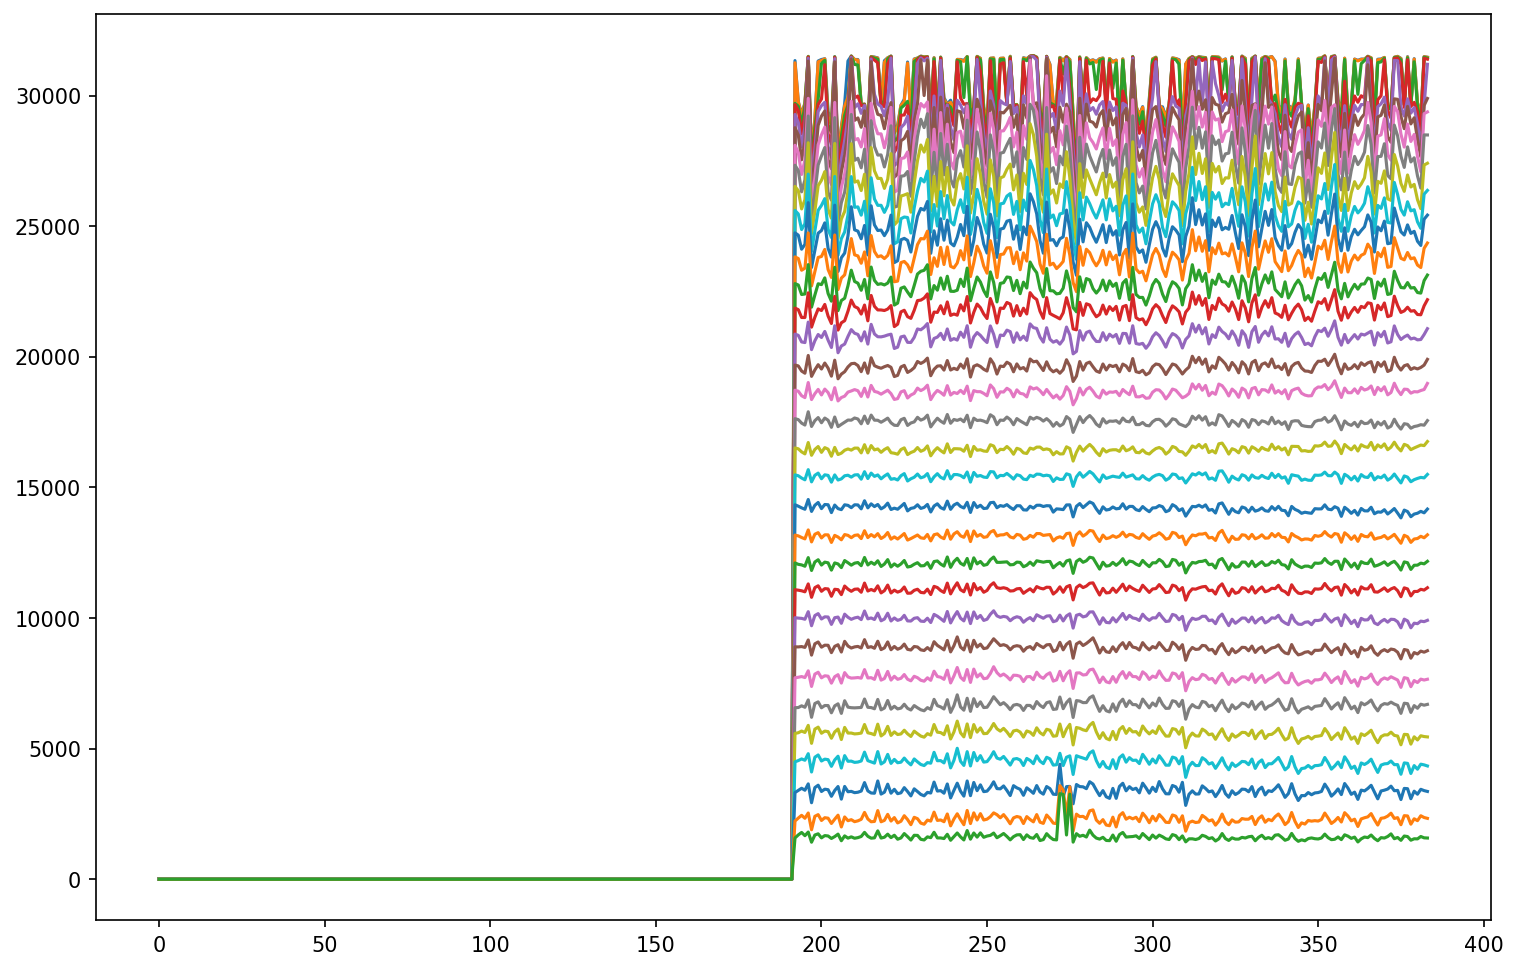

In [33]:
if ANALYSE_C:
    dfile = h5py.File(h5_filename, 'r')
    dfile.visit(printname)
    
    imgDesc = dfile['/adcData']
    for i in range(0,6):
        headers[:,i] = dfile['header_%d'%i]
    
    
    print(imgDesc.shape)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(imgDesc[1000])
    plt.figure(2,figsize=(12,8),dpi=150)
    maxRange = imgDesc.shape[0] if (imgDesc.shape[0] < int(65000/SCAN_STEP_C))  else int(65000/SCAN_STEP_C)
    for imgIdx in np.arange(0, maxRange,int(2000/SCAN_STEP_C )):
        plt.plot(imgDesc[imgIdx,20,:])

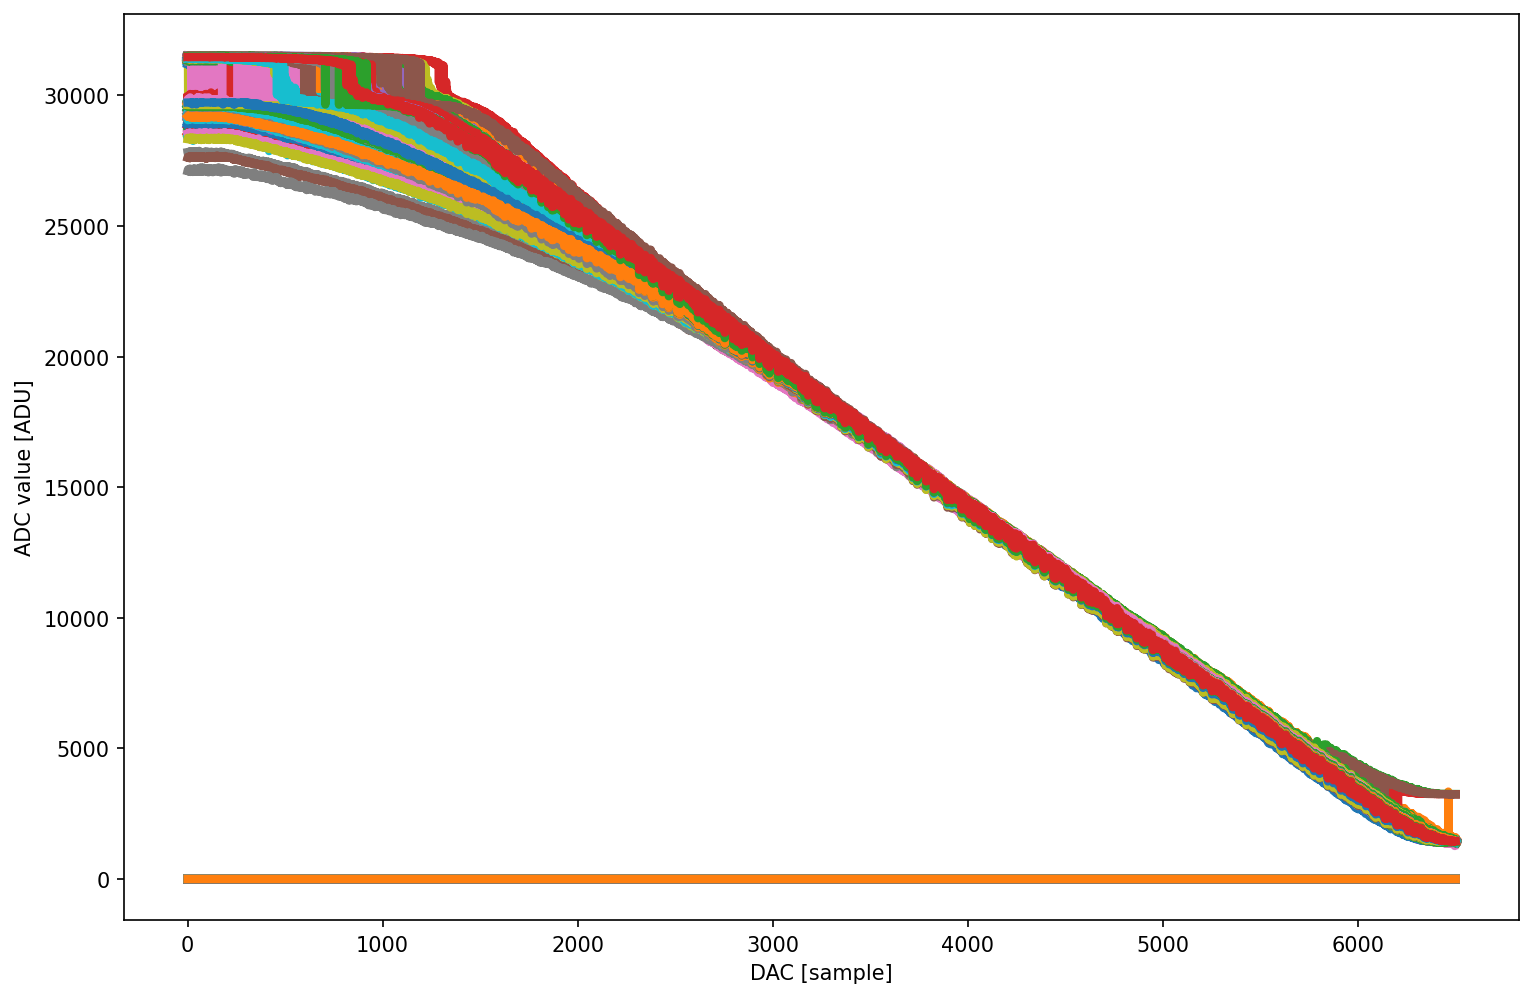

In [34]:
if ANALYSE_C:
    plt.figure(1,figsize=(12,8),dpi=150)
    for column in np.arange(384):
        plt.plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
    plt.xlabel('DAC [sample]')
    plt.ylabel('ADC value [ADU]')
    plt.show()

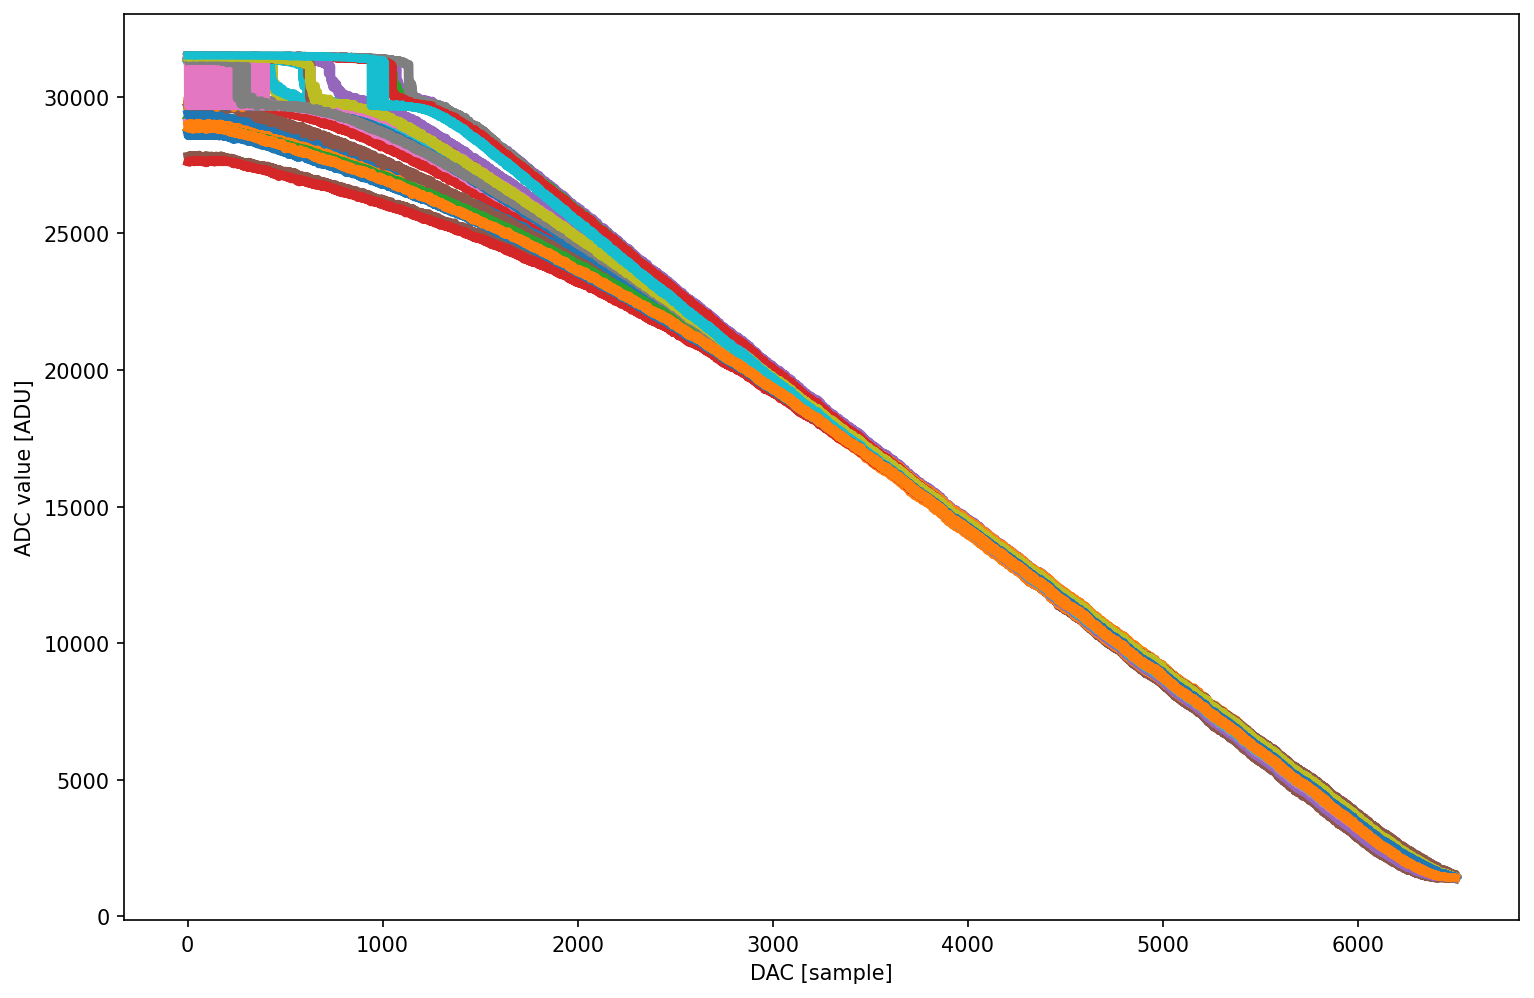

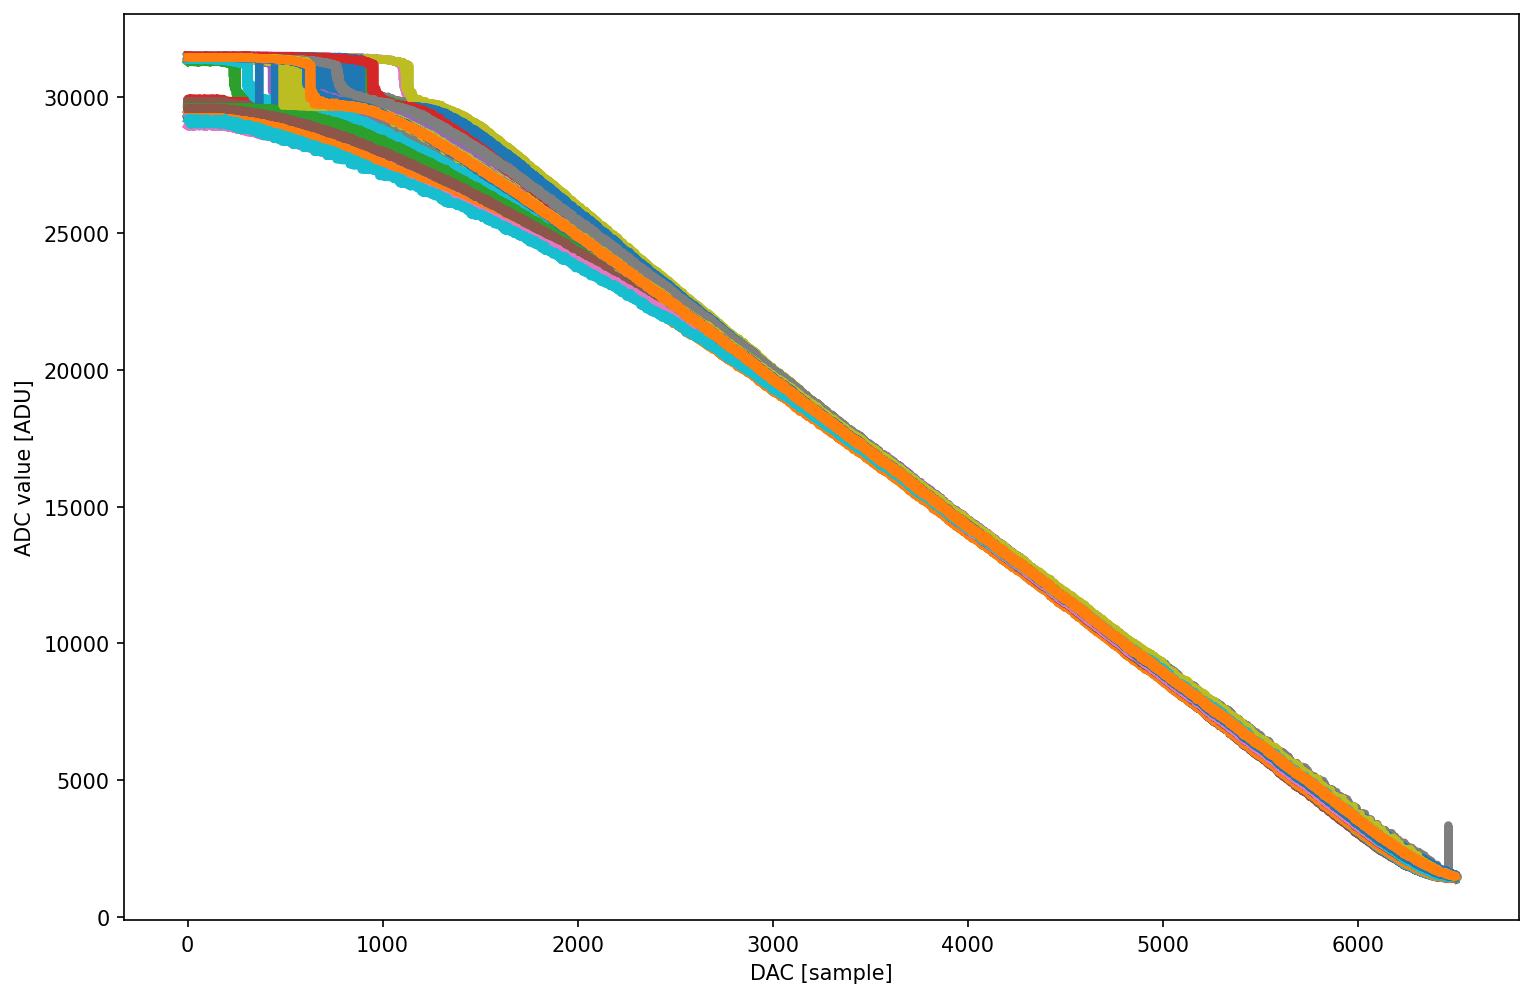

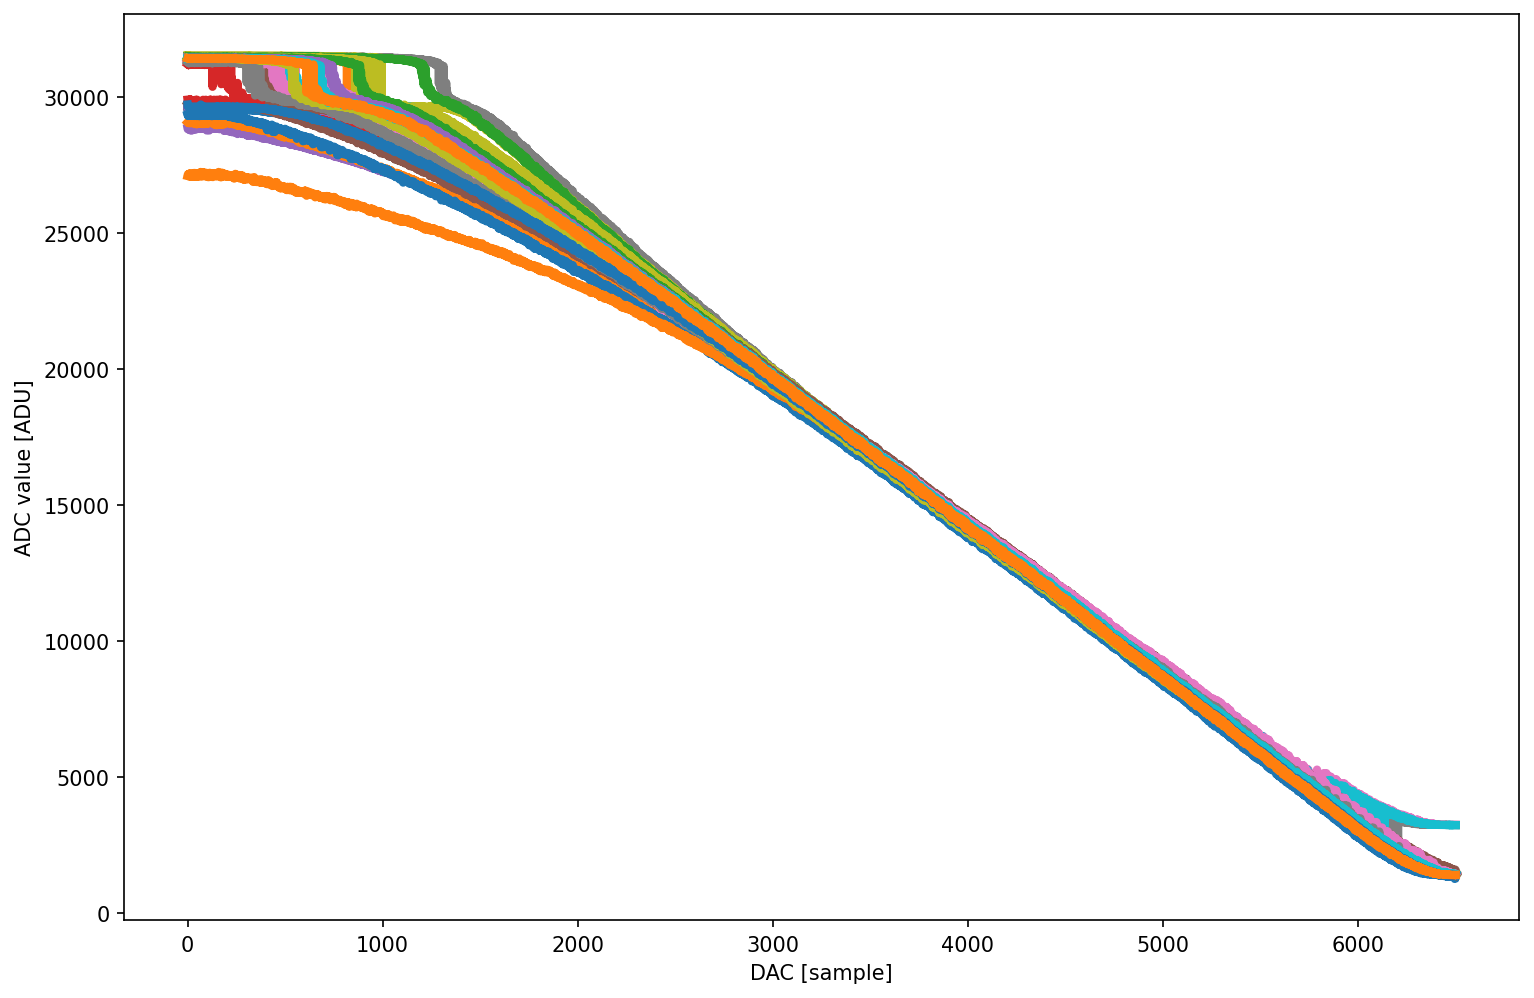

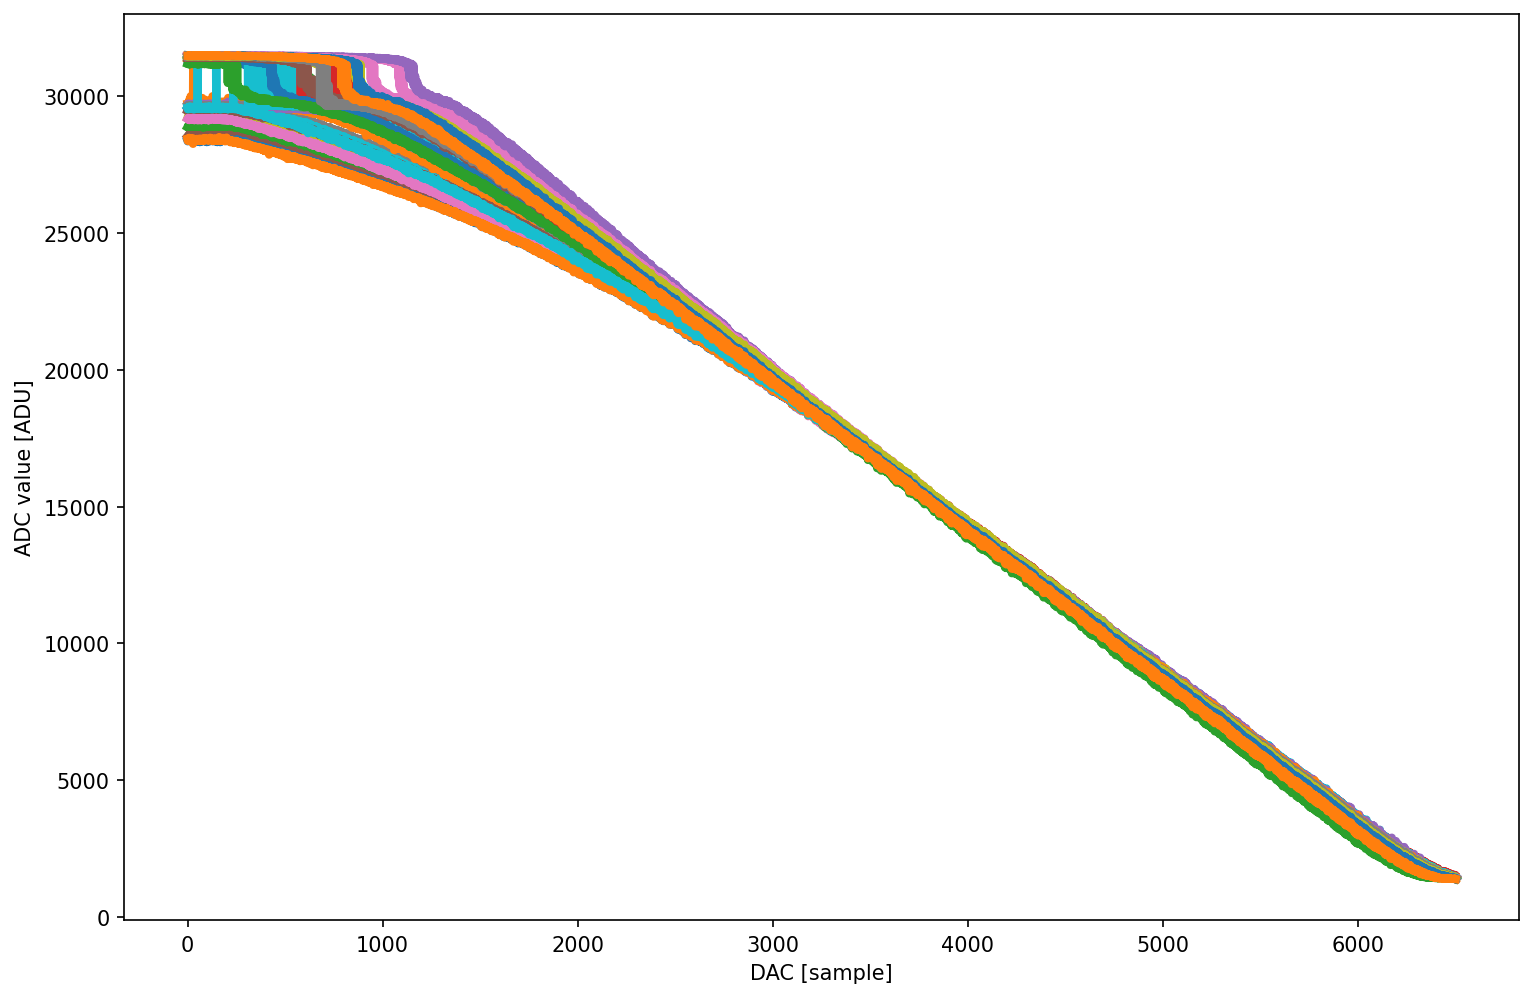

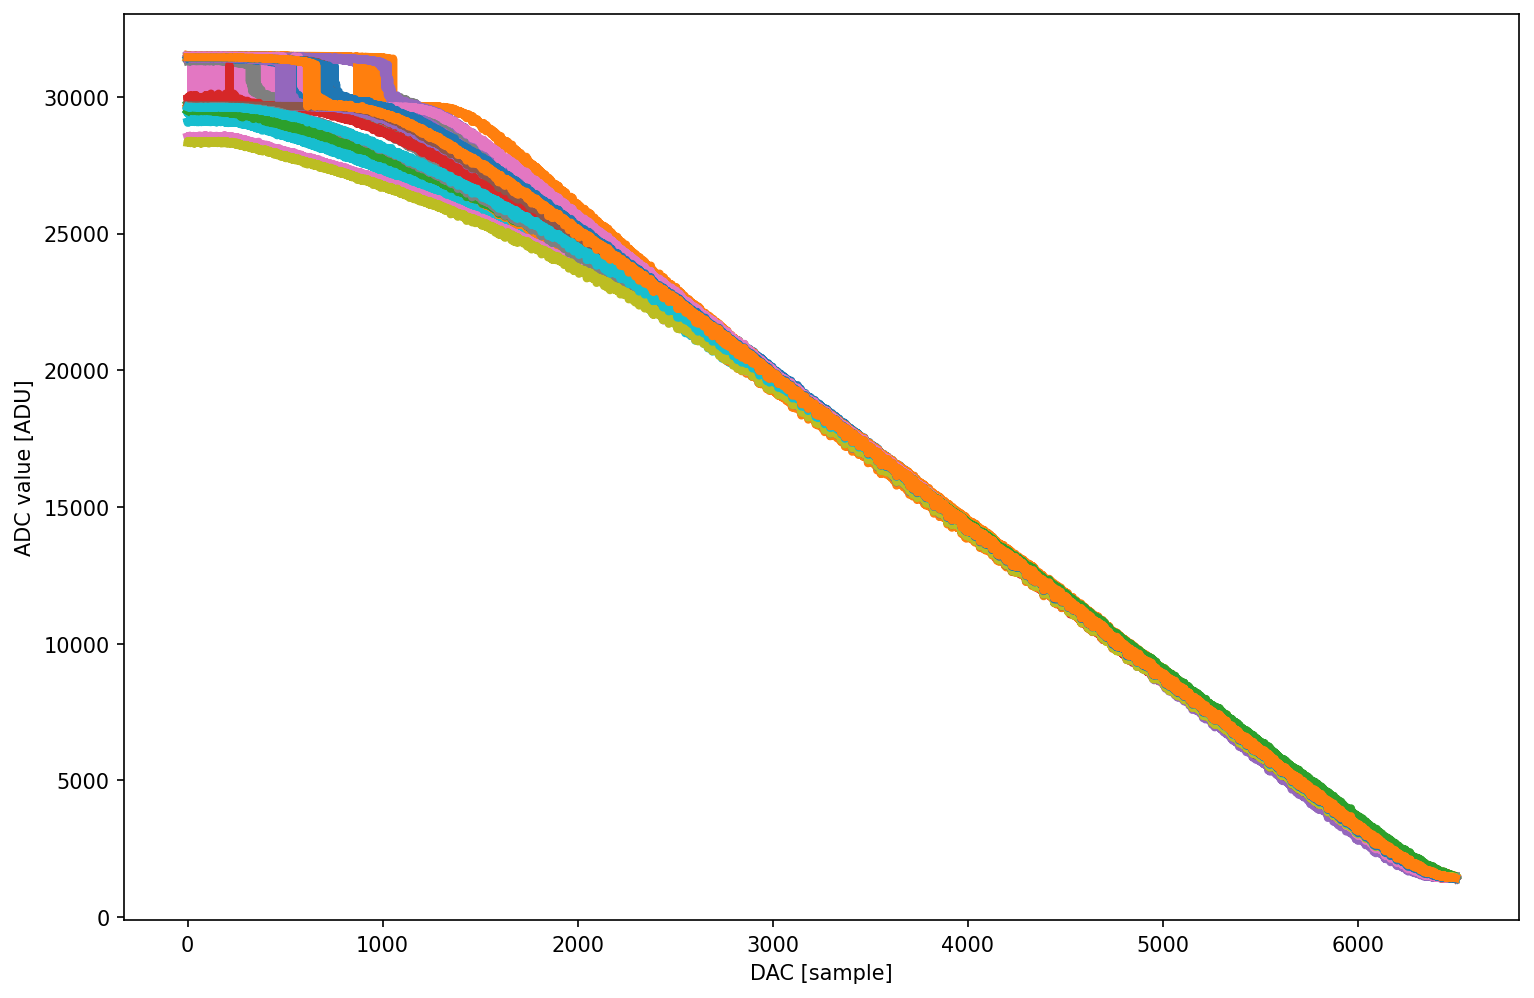

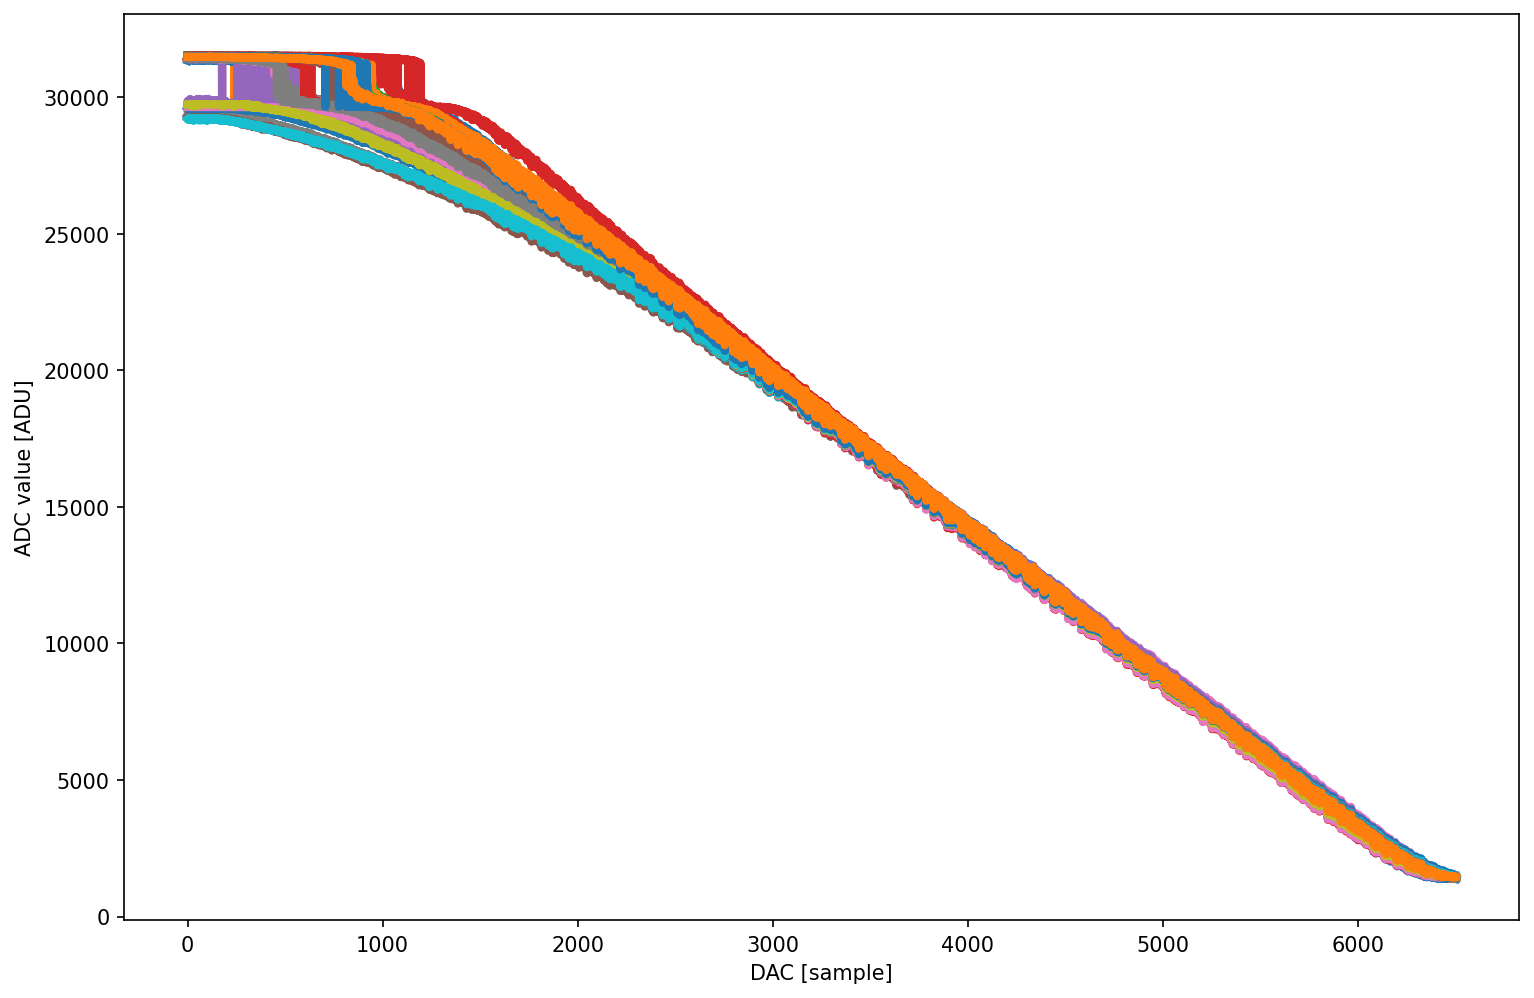

In [35]:
if ANALYSE_C:
    for startCol in np.arange(192,384,32):
        plt.figure(1,figsize=(12,8),dpi=150)
        for column in np.arange(startCol,startCol+32):
            plt.plot(np.linspace(0, maxRange, maxRange), imgDesc[0:maxRange,10, column], linewidth=4)
        plt.xlabel('DAC [sample]')
        plt.ylabel('ADC value [ADU]')
        plt.show()


(5000,)
Fitting parameters for ADC Channel [192]
 
-0.1857 x + 5136


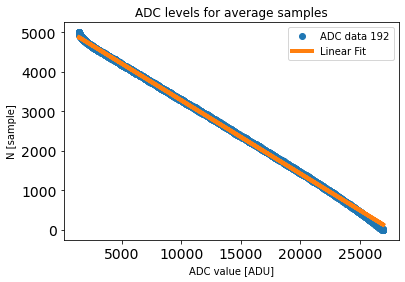

limits are [26077, 1868]


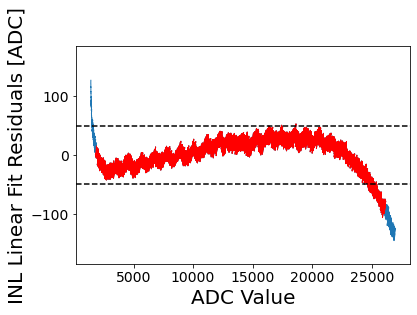

MeasuredMadDevLinFit 106.07827415597785
(5000,)
Fitting parameters for ADC Channel [208]
 
-0.1872 x + 5151


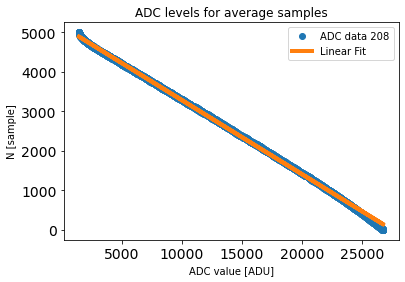

limits are [25941, 1869]


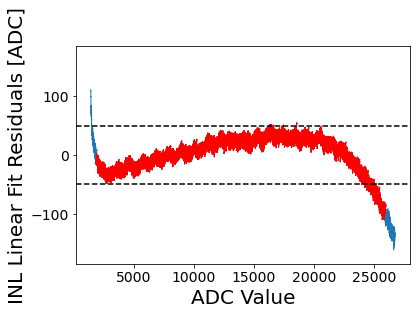

MeasuredMadDevLinFit 109.96691196080974


In [81]:
if ANALYSE_C:
    CHANNEL_INDEX_CTE = np.arange(192,384,16)
    BANK_C = 0
    CHANNEL_INDEX_CTE = np.arange(192+32*BANK_C,192+32*BANK_C+32,16)
    linearStartRange = int(15000/SCAN_STEP_C)
    linearEndRange = int(65000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    for column in CHANNEL_INDEX_CTE:
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        print(reducedDataSubset.shape)

        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        print("Fitting parameters for ADC Channel [%d]" %(column))
        print(f)

        x_est = x
        y_est = f(x_est)

        #plt.figure(1,figsize=(12,8),dpi=150)
        plt.title('ADC levels for average samples')
        plt.ylabel('N [sample]')
        plt.xlabel('ADC value [ADU]')
        plt.plot(x, y, 'o', x_est, y_est, linewidth=4)
        plt.legend([f'ADC data {column}', 'Linear Fit'])
        plt.show()

        x_diff = x
        y_diff = (y - y_est)

        print("limits are [%d, %d]" % (x_diff[startIndex],x_diff[stopIndex]))
        figureIndex += 0
        #plt.figure(1,figsize=(12,8),dpi=150)
        plt.rc('xtick', labelsize=14) 
        plt.rc('ytick', labelsize=14) 
        #plt.title('ADC level difference to linear fit')
        plt.ylabel('INL Linear Fit Residuals [ADC]', fontsize=20)
        plt.xlabel('ADC Value', fontsize=20)
        plt.plot(x_diff, y_diff, linewidth=1)
        plt.plot(x_diff[startIndex:stopIndex], y_diff[startIndex:stopIndex], 'r', linewidth=1)
        plt.ylim(-185,185)
        plt.axhline(50.0, color='black',linestyle='--') # cutoff frequency
        plt.axhline(-50.0, color='black',linestyle='--') # cutoff frequency
        #plt.savefig('cryoDiffLinearFit.png', dpi=300)
        #plt.savefig(os.path.splitext(filename)[0]+"corr_factor_"+ str(MID_SCALE_CORR_CTE) +"_channel_" + str(channelIndex) + "_figure_" + str(figureIndex) +".png")
        plt.show()

        MeasuredMadDevLinFit = np.max(np.abs(y_diff[startIndex:stopIndex]))
        print('MeasuredMadDevLinFit', MeasuredMadDevLinFit)

In [132]:
if ANALYSE_C:
    CHANNEL_INDEX_CTE = np.arange(192,384,1)
    #BANK_C = 0
    #CHANNEL_INDEX_CTE = np.arange(192+32*BANK_C,192+32*BANK_C+32,1)
    linearStartRange = int(15000/SCAN_STEP_C)
    linearEndRange = int(65000/SCAN_STEP_C)
    row = 10
    figureIndex = 0
    loopIndex = 0
    gainList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    measuredMaxDevLinFit = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    rangeList = np.zeros(CHANNEL_INDEX_CTE.shape[0])
    for column in CHANNEL_INDEX_CTE:
        
        rangeList[loopIndex] = np.max(imgDesc[linearStartRange:linearEndRange,row,column]) - np.min(imgDesc[linearStartRange:linearEndRange,row,column])
        
        reducedDataSubset = imgDesc[linearStartRange:linearEndRange,row,column]
        
        #from scipy import signal
        y = np.arange(0,reducedDataSubset.shape[0])#linearStartRange, linearEndRange)[0:65535:11]
        #x = signal.resample(avgdataSubset, 65536)
        x = reducedDataSubset

        #[x>2047] = y[x>2047] + MID_SCALE_CORR_CTE

        #print('Shape downsampled' , x.shape)
        startIndex = int(2000/SCAN_STEP_C)
        stopIndex = reducedDataSubset.shape[0]-(int(2000/SCAN_STEP_C))

        z = np.polyfit(x[startIndex:stopIndex], y[startIndex:stopIndex], 1)
        f = np.poly1d(z)
        gainList[loopIndex] = f[1]
        
        x_est = x
        y_est = f(x_est)


        x_diff = x
        y_diff = (y - y_est)

               

        measuredMaxDevLinFit[loopIndex] = np.max(np.abs(y_diff[startIndex:stopIndex]))
                
        loopIndex +=1
        


[[ 1.92000000e+02 -1.85688061e-01  1.06078274e+02  2.55340000e+04]
 [ 1.93000000e+02 -1.86824787e-01  1.13018528e+02  2.52830000e+04]
 [ 1.94000000e+02 -1.91965460e-01  1.52218729e+02  2.45050000e+04]
 [ 1.95000000e+02 -1.90405508e-01  1.12531547e+02  2.49880000e+04]
 [ 1.96000000e+02 -1.80126373e-01  5.80307963e+01  2.72800000e+04]
 [ 1.97000000e+02 -1.92018503e-01  2.53679242e+02  2.36180000e+04]
 [ 1.98000000e+02 -1.92676092e-01  1.68833367e+02  2.44890000e+04]
 [ 1.99000000e+02 -1.88281748e-01  9.66599937e+01  2.55030000e+04]
 [ 2.00000000e+02 -1.85934476e-01  5.37837720e+01  2.58290000e+04]
 [ 2.01000000e+02 -1.84066645e-01  5.21754433e+01  2.61480000e+04]
 [ 2.02000000e+02 -1.91030747e-01  1.74850894e+02  2.45480000e+04]
 [ 2.03000000e+02 -1.91557896e-01  1.75092680e+02  2.42130000e+04]
 [ 2.04000000e+02 -1.78902049e-01  6.85246180e+01  2.72920000e+04]
 [ 2.05000000e+02 -1.99928029e-01  2.39034804e+02  2.33920000e+04]
 [ 2.06000000e+02 -1.90571348e-01  1.99465813e+02  2.41700000e

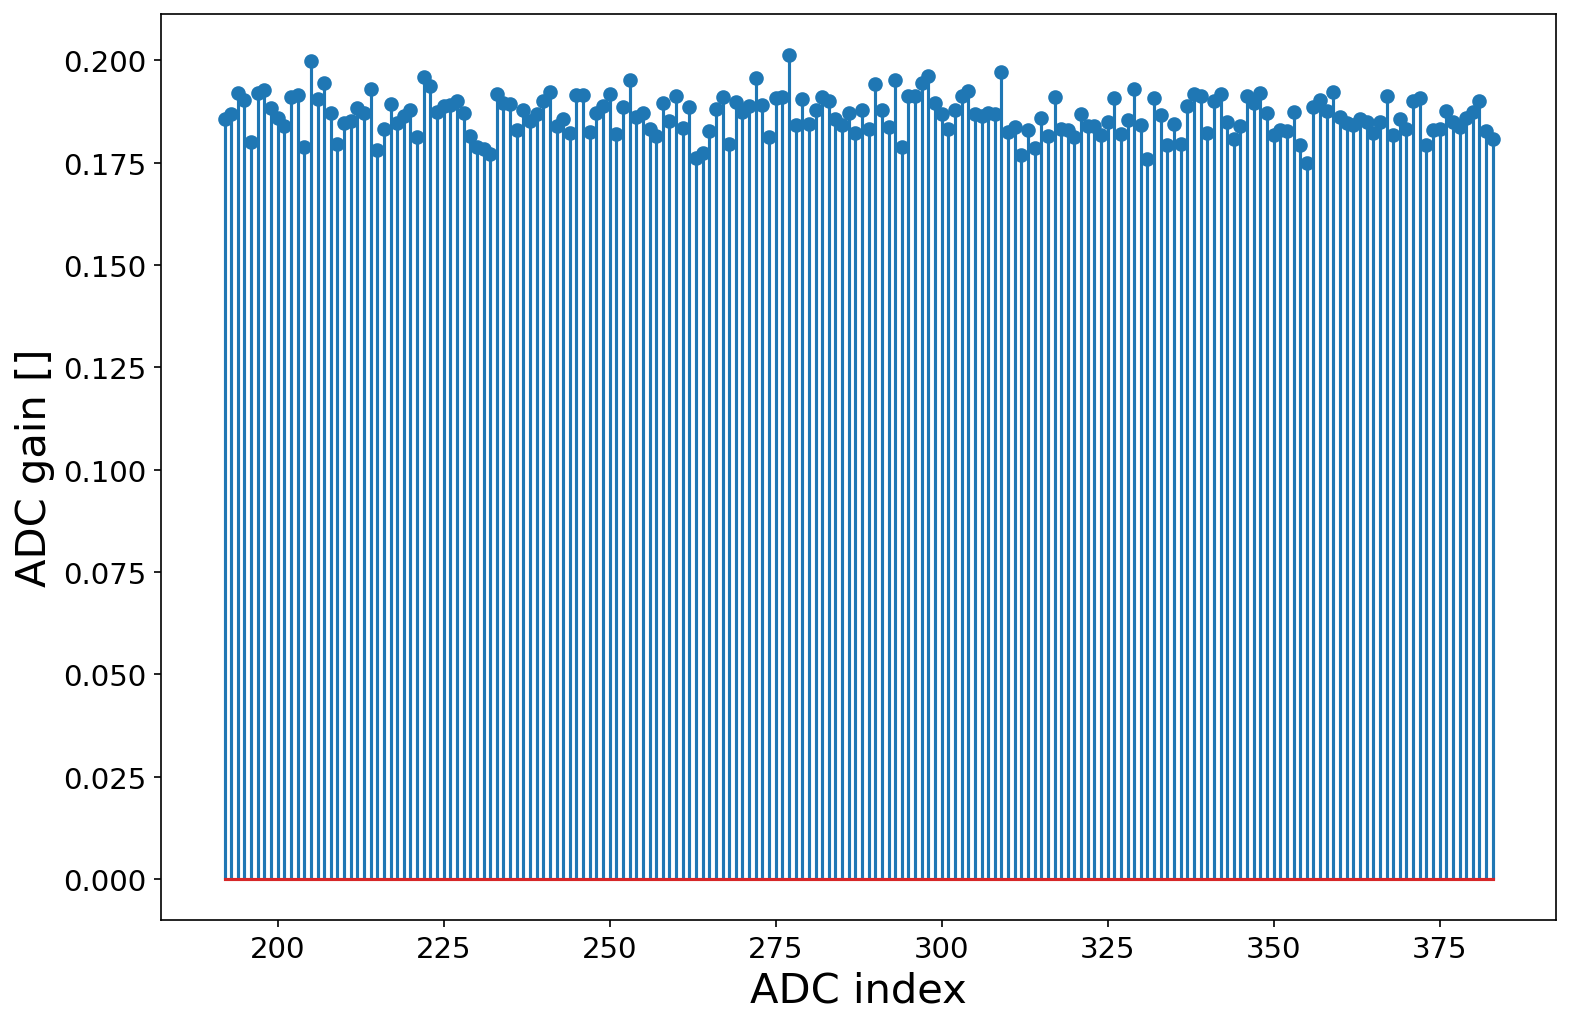

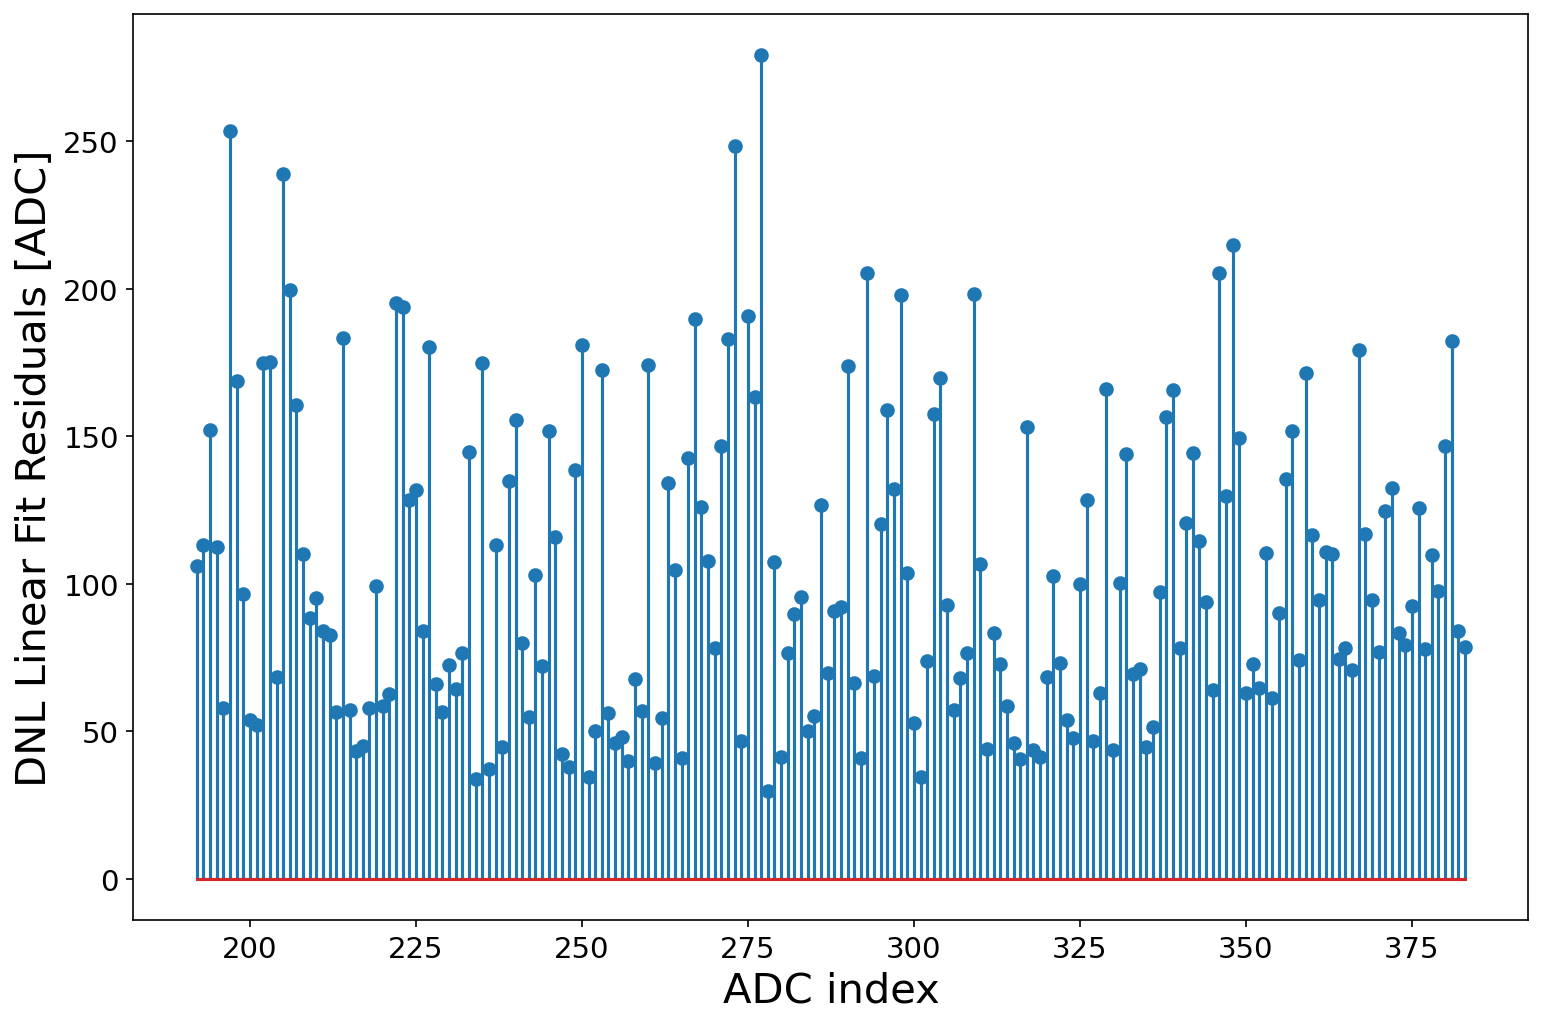

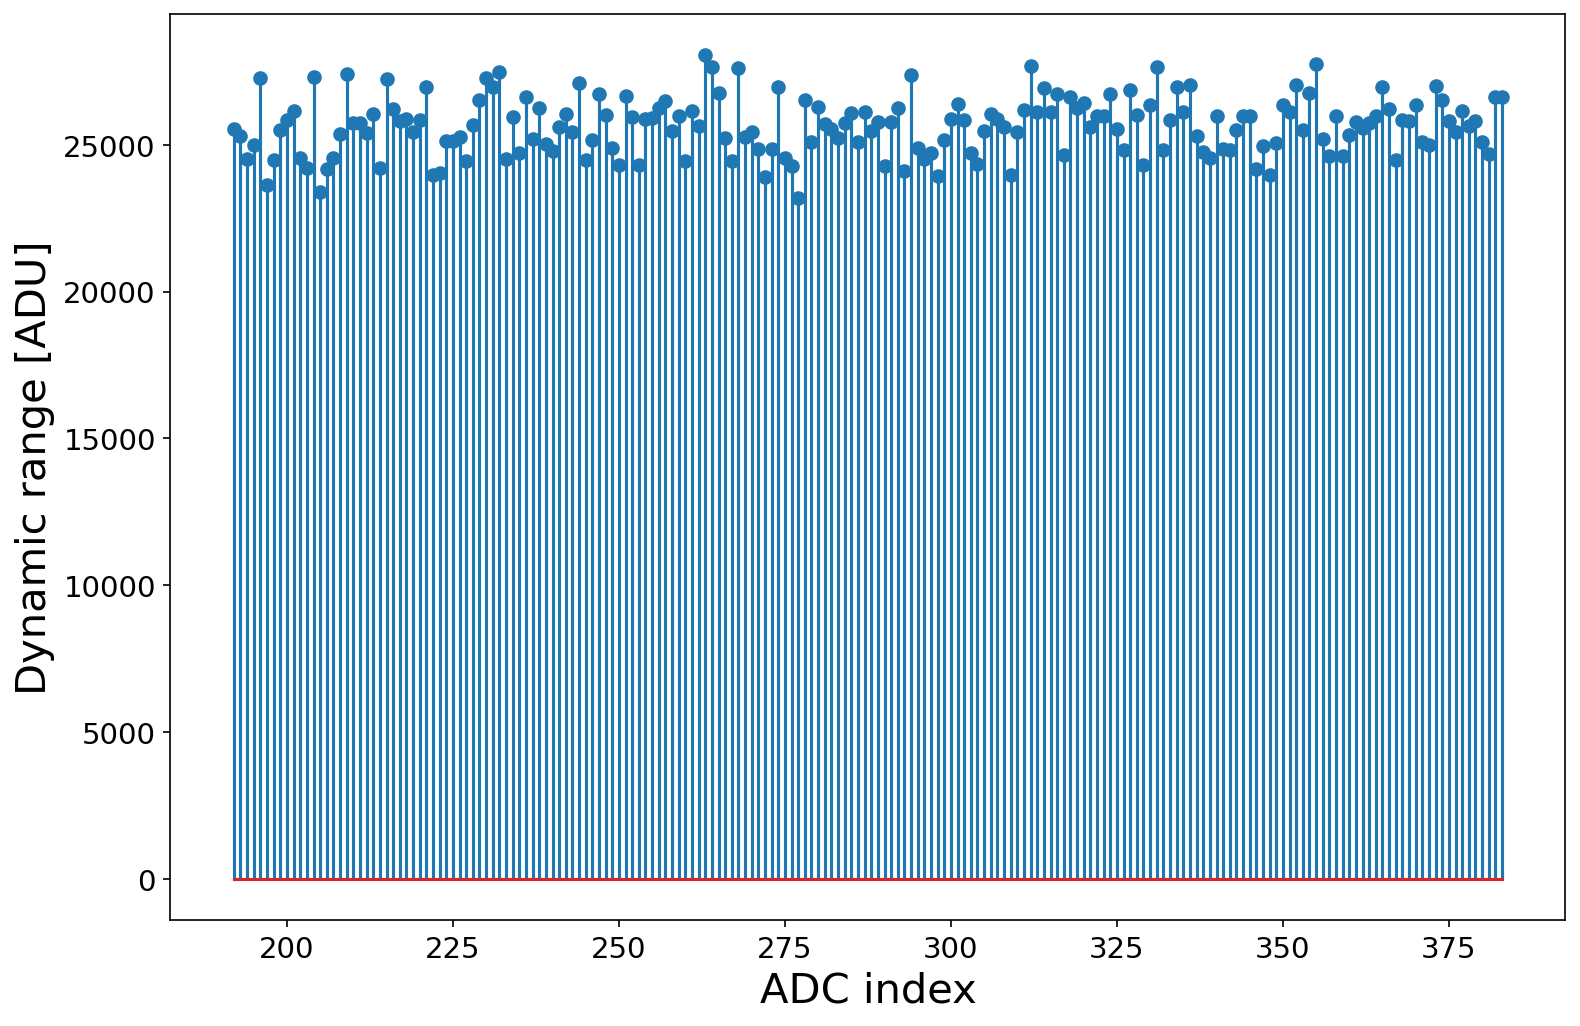

In [134]:
summary = []
summary.append(CHANNEL_INDEX_CTE)
summary.append(gainList)
summary.append(measuredMaxDevLinFit)
summary.append(rangeList)

summary_np = np.asarray(summary)
print(summary_np.transpose())

plt.figure(1,figsize=(12,8),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('ADC gain []', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(gainList))
plt.show()

plt.figure(1,figsize=(12,8),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('DNL Linear Fit Residuals [ADC]', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(measuredMaxDevLinFit))
plt.show()

plt.figure(1,figsize=(12,8),dpi=150)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
#plt.title('ADC level difference to linear fit')
plt.ylabel('Dynamic range [ADU]', fontsize=20)
plt.xlabel('ADC index', fontsize=20)
plt.stem(CHANNEL_INDEX_CTE, np.abs(rangeList))
plt.show()

-0.18334665745588025

In [91]:
whos

Variable                         Type                Data/Info
--------------------------------------------------------------
ACQUIRE_C                        bool                True
ANALYSE_C                        bool                True
ASIC                             EpixHr10kTV3Asic    <class 'ePixAsics._ePixAs<...>Hr10kT.EpixHR.Hr10kTAsic3
AcqCount                         int                 3578887
AxiVersion                       AxiVersion          <class 'epix_hr_core._Axi<...>PixHr10kT.Core.AxiVersion
BANK_C                           int                 0
CHANNEL_INDEX_CTE                ndarray             4: 4 elems, type `int64`, 32 bytes
CONVERT_C                        bool                True
DeltaAcqCount                    int                 7006
MAX_NUMBER_OF_FRAMES_PER_BATCH   int                 1000
MeasuredMadDevLinFit             float64             43.47761365861152
SAVEHDF5                         bool                True
SCAN_STEP_C                      